In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
import h5py

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [2]:
def metric_by_radius(y_true, y_pred, r):
    
    true_positives = 0  # they are true, and we chosen them
    false_negatives = 0 # they are true, but we haven't chosen them
    false_positives = 0  # they are false, but we chosen them

    indices_good = set()

    for i in range(len(y_true)):
        dist = np.linalg.norm(y_pred - y_true[i], axis=1)


        true_positives += int(len(dist[dist <= r]) > 0)


        cur_true_indices = np.where(dist <= r)[0]
        if len(cur_true_indices) > 0:
            indices_good.update([cur_true_indices[0]])
        else:
            false_negatives += 1


    false_positives = len(y_pred) - len(indices_good)


    return true_positives, false_positives, false_negatives

In [3]:
def get_prob_of_dipole(output, batch_number):
    one_pred = []

    one_pred.append(output[1, batch_number])
    one_pred.append(output[2, batch_number])

    one_pred = np.array(one_pred)
    one_pred = np.transpose(one_pred, (1,2,3,0))
    proba_one = softmax(one_pred, axis=3)

    return proba_one[:, :, :, 1]


def output_to_coords(array, threshold):
    array = array.squeeze()

    return np.array(np.where(array.squeeze() > threshold)).T

In [4]:
# from cubes in space return the centeres of the cudes := inverce of augmentation function
def deaugmentation(y, grid, AUG=2):
    y_deaugmented = np.zeros((grid,grid,grid))
    y_augmented = np.zeros((grid,grid,grid))

    mask = np.ones((AUG*2+1,AUG*2+1,AUG*2+1)).tolist()
    for coord in y:
        y_augmented[tuple(coord.tolist())] = 1
    for coord in  np.ndindex(y_augmented.shape):
        if y_augmented[coord[0]-AUG:coord[0]+AUG+1,
                       coord[1]-AUG:coord[1]+AUG+1,
                       coord[2]-AUG:coord[2]+AUG+1].tolist() == mask: y_deaugmented[coord] = 1

    return np.array(np.where(y_deaugmented == 1)).T

In [92]:

def load_output(output, batch_size, grid, augmented=False, do_print=False):

    # (4, 8, 64, 64, 64) - output shape 1 and 2 channels - background and dipoles
    
    for batch_number in range(0, batch_size):
        y_pred = get_prob_of_dipole(output, batch_number)
        y_true = output[3, batch_number].squeeze()

        if do_print:
            print(y_true.shape, np.min(y_true), np.max(y_true), np.mean(y_true))
            print(y_pred.shape, np.min(y_pred), np.max(y_pred), np.mean(y_pred))
        
        
        y_true = output_to_coords(y_true, 0.5)
        y_pred = output_to_coords(y_pred, 0.72)
        

        if do_print:
            print(y_true.shape, np.min(y_true), np.max(y_true), np.mean(y_true))
            print(y_pred.shape, np.min(y_pred), np.max(y_pred), np.mean(y_pred))
        if augmented:
            y_true = deaugmentation(y_true, grid, AUG=2)
            
        yield y_true, y_pred

In [53]:

def metric(output, rng, batch_size, grid, augmented=False):
    batch_result = []
    for (y_true, y_pred) in tqdm(load_output(output, batch_size, grid, augmented)):
        result = []
        for r in np.arange(0, rng):
            
            

            try:
                ac = AgglomerativeClustering(n_clusters=None, distance_threshold=r)
                y_pred_clusters = ac.fit_predict(y_pred, 2)

                temp = []
                for cluster_n in range(max(y_pred_clusters)):
                    temp.append(y_pred[y_pred_clusters == cluster_n].mean(axis=0))

                y_pred = np.array(temp)

                r_result = metric_by_radius(y_true, y_pred, r)
                result.append(r_result)

            except ValueError:
                
                result.append(np.array([0,0,0]))
                continue


        batch_result.append(result)
        # result.append(list(r_result) + [r_result[0] + r_result[1], max(y_pred_clusters)])

    return np.array(batch_result)

In [7]:
def f1_r(tp, fp, fn, r, label=None):
    f1_score = tp / (tp + 1/2*(fp + fn))

    # plt.plot(r, f1_score, marker='o', label=label)
    # plt.xlabel('radius')
    # plt.ylabel('f1 score')
    return f1_score.tolist()

In [ ]:
data = h5py.File('C:/Users/spaik/Desktop/test/vnet_CrossEntropy_AUGMENTATION-None-4000-pred-epochs-120.h5', 'r')
keys = list(data.keys())

global_results = []
for batch_id in range(len(data)):
    output = data[keys[batch_id]]
    batch_results = metric(output, rng=10, batch_size=8, grid=64, augmented=False)
    global_results.append(batch_results)


In [187]:
# np.savez_compressed('C:/Users/spaik/Desktop/metrics/vnet_CrossEntropy_AUGMENTATION-None-4000-pred-epochs-120-thr-0.72.npz', np.array(global_results))
global_results = np.load('C:/Users/spaik/Desktop/metrics/vnet_CrossEntropy_AUGMENTATION-None-4000-pred-epochs-120-thr-0.72.npz')
global_results = global_results['arr_0']

In [109]:
# random_dots - 5 arrays (10, 100, 1000, 10000, 100000) with mean
# and std for different radius (from 0 to 10)

random_dots = [(np.array([0.        , 0.00131579, 0.00131579, 0.00394737, 0.00922807,
         0.02891365, 0.04829474, 0.08815958, 0.12940027, 0.17222693]),
  np.array([0.        , 0.00573539, 0.00573539, 0.00939662, 0.01912879,
         0.03204208, 0.04498496, 0.05009552, 0.05944999, 0.08234616])),
 (np.array([0.        , 0.00155039, 0.00544462, 0.02892009, 0.06434668,
         0.12129317, 0.19052411, 0.28998764, 0.40207362, 0.4898116 ]),
  np.array([0.        , 0.00465116, 0.00741995, 0.01807085, 0.02976045,
         0.04488718, 0.03819956, 0.04783885, 0.06133034, 0.05694628])),
 (np.array([0.        , 0.00323977, 0.01804566, 0.04934698, 0.10221175,
         0.18154454, 0.26491887, 0.34804142, 0.42231814, 0.47575555]),
  np.array([0.        , 0.00269204, 0.00641606, 0.01541013, 0.02049377,
         0.02344445, 0.02602638, 0.01925914, 0.01429087, 0.01142512])),
 (np.array([0.        , 0.00177927, 0.01529439, 0.04141366, 0.07739052,
         0.10968165, 0.13480457, 0.15552151, 0.17497888, 0.1948055 ]),
  np.array([0.        , 0.00138854, 0.00354078, 0.00336333, 0.00423679,
         0.00251234, 0.00132979, 0.00151926, 0.00192673, 0.00272703])),
 (np.array([0.        , 0.0021175 , 0.01106643, 0.02111316, 0.02854416,
         0.03597633, 0.04345906, 0.05126714, 0.05902984, 0.06680566]),
  np.array([0.        , 0.00040904, 0.00073354, 0.00034265, 0.00013627,
         0.00016559, 0.0001527 , 0.00030113, 0.0003078 , 0.0002667 ]))]

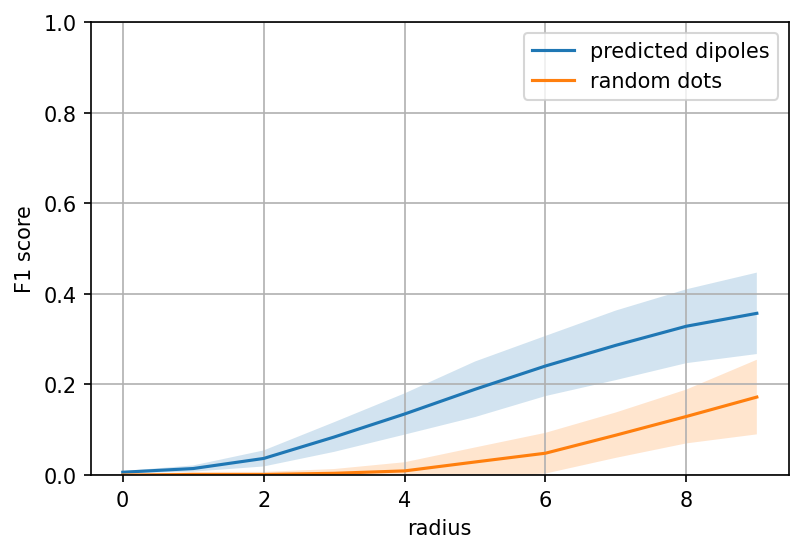

In [188]:
f1_scores = []
empty = np.array([0,0,0])
for batch_results in global_results:
    for image in batch_results:
        if empty in image:
            continue
        else:
            f1_scores.append(f1_r(*image.T, np.arange(10)))
f1_scores = np.array(f1_scores).T
over_all_scores = (f1_scores.mean(axis=1), f1_scores.std(axis=1))
plt.plot(range(10), over_all_scores[0], label='predicted dipoles')
plt.fill_between(range(10), over_all_scores[0]-over_all_scores[1], over_all_scores[0]+over_all_scores[1], alpha=0.2)

plt.plot(range(10), random_dots[0][0], label='random dots')
plt.fill_between(range(10), random_dots[0][0]-random_dots[0][1], random_dots[0][0]+random_dots[0][1], alpha=0.2)

plt.grid()
plt.xlabel('radius')
plt.ylabel('F1 score')
plt.ylim([0,1])
plt.legend()
# plt.savefig('C:/Users/spaik/Desktop/metrics/vnet_CrossEntropy_AUGMENTATION-None-4000-pred-epochs-270.jpg')